In [1]:
# Alpha_RNNs-HFT
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, statsmodels=0.10.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how Keras can be used to train and test TensorFlow RNNs for time series prediction. The example dataset is for predicting from noisy, non-stationary data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationary data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parametric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured. 

#### Statistician's note
- We choose to build a model which provides strong predictive power, at the expense of reduced explanatory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' - identifying the relevant features to include in the model. 

- In this notebook, we assume that we've already identifed the relevant set of features (i.e. there is only one time series provided).
- Our primary concern is assessing the extent to which the model is over-fitting, by comparing the in- and out-of-sample MSEs.

#### Implementation notes
- It is important to ensure that `shuffle=False` in the fit function, otherwise the ordering of sequences is not preserved. This is especially important for methods which have memory beyond the current sequence (i.e. all methods except RNNs).
- Time series cross-validation must be used for hyper-parameter tuning because the ordering of the data matters. In particular, the model must never use training data more recent than the forecasting observation date.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

# note that the directory containing these two .py's must be in the path variable:
from alphaRNN import AlphaRNN
from alphatRNN import AlphatRNN


/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
%matplotlib inline

### Example Data
- The example dataset is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- For simplicity, since the timestamps are not important for this tutorial, an integer index has been used for the Pandas Dataframe. A real dataset would typically be indexed by a unique timestamp. The observations are not uniform and in general are less than a micro-second apart.

- Each observation $X$ has three variables (a.k.a. features). Feature 3 is the smart price (VWAP) and the label indicates whether the book will up-tick, stay flat or down-tick in the next time interval.

Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [4]:
df = pd.read_csv('../data/HFT.csv')

In [5]:
df.head(10)

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0
5,0.515301,0.72,0.710953,0
6,0.515301,0.72,0.710953,0
7,0.515301,0.72,0.710953,0
8,0.515301,0.72,0.710953,0
9,0.515301,0.72,0.710953,0


# RNN Regression
We consider a univariate prediction problem where the time series is given by 'feature_3' in the data frame, and for each input sequence we predict the value 10 time-steps into the future.

In [6]:
use_features = ['feature_3'] # continuous input
target = ['feature_3'] # continuous output
n_steps_ahead = 10 # forecasting horizon

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostics tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the computation time of the test.

In [7]:
sample = df['feature_3'][:20000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [8]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -5.314335374054756
p-value: 5.11341915615086e-06,
N: 19964, 
critical values: {'1%': -3.4306775967247427, '5%': -2.8616847862243144, '10%': -2.5668470657535196}


#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}}
,\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimat the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [9]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

Since $\Phi^{-1}(0.99) \simeq 2.58$:

In [10]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [11]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 23


This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 2 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

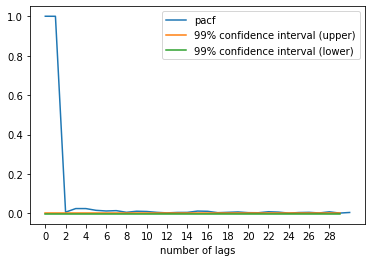

In [12]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.xticks(np.arange(0,30,2))
plt.legend();

### Splitting the time series into training and testing sets
Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [13]:
train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [14]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = np.float(df_train.mean())
sigma = np.float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [15]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

We shall first transform the training input and output data.

In [16]:
x_train = get_lagged_features(df_train[use_features], n_steps, n_steps_ahead)
y_train =  df_train[target].values[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test[use_features], n_steps, n_steps_ahead)
y_test =  df_test[target].values[n_steps + n_steps_ahead - 1:]

Print the shapes of each tensor. The first digit is the number of observations. For feature arrays, the second digit is the sequence length (i.e. the number of lags in the model) and the final digit is the dimension of each element in the sequence or output vector respectively. In this case, the example performs univariate time series analysis and so the dimension of the input and output is 1.

In [17]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(826793, 23, 1), (826793, 1), (206675, 23, 1), (206675, 1)]


### Model Specification

In [18]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [19]:
max_epochs = 20
batch_size = 1000

In [20]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [21]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'alpharnn': {
        'model': None, 'function': AlphaRNN_, 'l1_reg': 0.0, 'H': 10, 
        'color': 'green', 'label': '$\\alpha$-RNN' }, 
    'alphatrnn': {
        'model': None, 'function':AlphatRNN_, 'l1_reg': 0.0, 'H': 5, 
        'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

# Cross-validation

The cell below performs a grid search to optimise the `n_units` and `l1_reg` for each of the models. 

The results are cross-validated to avoid over-fitting. Scikit-Learn's `TimeSeriesSplit` function is used to partition the data into 5 pairs of training and testing sets, where the test data is always ahead of the training data in time. 

In [22]:
cross_val = False # Warning: Changing this to True will take several hours to run

if cross_val:
    n_units = [5]#, 10, 20]#¢#
    l1_reg = [0]#, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first 
    # k folds as train set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('*********', key)
        model = KerasRegressor(build_fn=params[key]['function'], epochs=3, 
                               batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

********* rnn
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
 - 7s - loss: 2.5277
Epoch 2/3
 - 3s - loss: 0.6123
Epoch 3/3
 - 3s - loss: 0.1460
[CV] .............................. l1_reg=0, n_units=5, total=  18.9s
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


Epoch 1/3
 - 10s - loss: 0.0065
Epoch 2/3
 - 7s - loss: 0.0050
Epoch 3/3
 - 7s - loss: 0.0050
[CV] .............................. l1_reg=0, n_units=5, total=  29.1s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 13s - loss: 0.0730
Epoch 2/3
 - 10s - loss: 0.0070
Epoch 3/3
 - 10s - loss: 0.0052
[CV] .............................. l1_reg=0, n_units=5, total=  38.0s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 18s - loss: 0.0706
Epoch 2/3
 - 14s - loss: 0.0072
Epoch 3/3
 - 14s - loss: 0.0053
[CV] .............................. l1_reg=0, n_units=5, total=  50.9s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 21s - loss: 0.4412
Epoch 2/3
 - 18s - loss: 0.0136
Epoch 3/3
 - 18s - loss: 0.0087
[CV] .............................. l1_reg=0, n_units=5, total= 1.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


Epoch 1/3
 - 25s - loss: 0.1118
Epoch 2/3
 - 21s - loss: 0.0069
Epoch 3/3
 - 21s - loss: 0.0056
Best: -0.018864 using {'l1_reg': 0, 'n_units': 5}
-0.018864 (0.016281) with {'l1_reg': 0, 'n_units': 5}
********* alpharnn
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
 - 15s - loss: 0.2758
Epoch 2/3
 - 6s - loss: 0.0346
Epoch 3/3
 - 7s - loss: 0.0142
[CV] .............................. l1_reg=0, n_units=5, total=  37.0s
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.0s remaining:    0.0s


Epoch 1/3
 - 21s - loss: 0.3324
Epoch 2/3
 - 13s - loss: 0.0349
Epoch 3/3
 - 16s - loss: 0.0106
[CV] .............................. l1_reg=0, n_units=5, total=  59.0s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 29s - loss: 1.5822
Epoch 2/3
 - 19s - loss: 0.1002
Epoch 3/3
 - 19s - loss: 0.0371
[CV] .............................. l1_reg=0, n_units=5, total= 1.3min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 35s - loss: 0.0746
Epoch 2/3
 - 26s - loss: 0.0059
Epoch 3/3
 - 25s - loss: 0.0052
[CV] .............................. l1_reg=0, n_units=5, total= 1.6min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 43s - loss: 0.3217
Epoch 2/3
 - 34s - loss: 0.0262
Epoch 3/3
 - 39s - loss: 0.0116
[CV] .............................. l1_reg=0, n_units=5, total= 2.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


Epoch 1/3
 - 64s - loss: 0.3278
Epoch 2/3
 - 47s - loss: 0.0085
Epoch 3/3
 - 56s - loss: 0.0071
Best: -0.075164 using {'l1_reg': 0, 'n_units': 5}
-0.075164 (0.111545) with {'l1_reg': 0, 'n_units': 5}
********* alphatrnn
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
 - 46s - loss: 0.8016
Epoch 2/3
 - 21s - loss: 0.0610
Epoch 3/3
 - 14s - loss: 0.0133
[CV] .............................. l1_reg=0, n_units=5, total= 1.8min
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


Epoch 1/3
 - 44s - loss: 3.1062
Epoch 2/3
 - 26s - loss: 0.4257
Epoch 3/3
 - 32s - loss: 0.0719
[CV] .............................. l1_reg=0, n_units=5, total= 2.0min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 64s - loss: 0.4743
Epoch 2/3
 - 38s - loss: 0.0210
Epoch 3/3
 - 46s - loss: 0.0091
[CV] .............................. l1_reg=0, n_units=5, total= 2.8min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 77s - loss: 0.4573
Epoch 2/3
 - 59s - loss: 0.0210
Epoch 3/3
 - 54s - loss: 0.0087
[CV] .............................. l1_reg=0, n_units=5, total= 3.7min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 74s - loss: 0.0661
Epoch 2/3
 - 61s - loss: 0.0064
Epoch 3/3
 - 70s - loss: 0.0055
[CV] .............................. l1_reg=0, n_units=5, total= 3.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.0min finished


Epoch 1/3
 - 113s - loss: 0.2135
Epoch 2/3
 - 80s - loss: 0.0075
Epoch 3/3
 - 74s - loss: 0.0060
Best: -0.085575 using {'l1_reg': 0, 'n_units': 5}
-0.085575 (0.107514) with {'l1_reg': 0, 'n_units': 5}
********* gru
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
 - 38s - loss: 0.1432
Epoch 2/3
 - 15s - loss: 0.0089
Epoch 3/3
 - 16s - loss: 0.0066
[CV] .............................. l1_reg=0, n_units=5, total= 1.6min
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/3
 - 53s - loss: 3.2539
Epoch 2/3
 - 35s - loss: 0.1602
Epoch 3/3
 - 29s - loss: 0.0450
[CV] .............................. l1_reg=0, n_units=5, total= 2.5min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 72s - loss: 0.2761
Epoch 2/3
 - 44s - loss: 0.0145
Epoch 3/3
 - 44s - loss: 0.0083
[CV] .............................. l1_reg=0, n_units=5, total= 3.1min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 80s - loss: 0.2712
Epoch 2/3
 - 62s - loss: 0.0082
Epoch 3/3
 - 59s - loss: 0.0059
[CV] .............................. l1_reg=0, n_units=5, total= 3.8min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 97s - loss: 2.1149
Epoch 2/3
 - 94s - loss: 0.0449
Epoch 3/3
 - 72s - loss: 0.0130
[CV] .............................. l1_reg=0, n_units=5, total= 4.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.9min finished


Epoch 1/3
 - 105s - loss: 0.1167
Epoch 2/3
 - 89s - loss: 0.0100
Epoch 3/3
 - 87s - loss: 0.0060
Best: -0.038000 using {'l1_reg': 0, 'n_units': 5}
-0.038000 (0.028946) with {'l1_reg': 0, 'n_units': 5}
********* lstm
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
 - 27s - loss: 0.8389
Epoch 2/3
 - 16s - loss: 0.0823
Epoch 3/3
 - 16s - loss: 0.0184
[CV] .............................. l1_reg=0, n_units=5, total= 1.2min
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/3
 - 48s - loss: 1.0614
Epoch 2/3
 - 29s - loss: 0.0440
Epoch 3/3
 - 29s - loss: 0.0143
[CV] .............................. l1_reg=0, n_units=5, total= 2.5min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 57s - loss: 0.1036
Epoch 2/3
 - 45s - loss: 0.0101
Epoch 3/3
 - 45s - loss: 0.0063
[CV] .............................. l1_reg=0, n_units=5, total= 2.7min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 72s - loss: 0.1450
Epoch 2/3
 - 60s - loss: 0.0065
Epoch 3/3
 - 60s - loss: 0.0055
[CV] .............................. l1_reg=0, n_units=5, total= 3.6min
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/3
 - 91s - loss: 0.2271
Epoch 2/3
 - 74s - loss: 0.0118
Epoch 3/3
 - 75s - loss: 0.0064
[CV] .............................. l1_reg=0, n_units=5, total= 4.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.9min finished


Epoch 1/3
 - 103s - loss: 0.2416
Epoch 2/3
 - 90s - loss: 0.0084
Epoch 3/3
 - 92s - loss: 0.0062
Best: -0.057962 using {'l1_reg': 0, 'n_units': 5}
-0.057962 (0.073743) with {'l1_reg': 0, 'n_units': 5}


# Train models with selected parameters

If the grid search was performed, the parameters `n_units` and `l1_reg` with the best cross-validated results on the training set are used. If not, the values from the initialisation of `params` above are used.

In [23]:
for key in params.keys():
    tf.random.set_seed(0)
    print('Training', key, 'model')
    model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
    model.fit(x_train, y_train, epochs=max_epochs, 
              batch_size=batch_size, callbacks=[es], shuffle=False)
    params[key]['model'] = model

Training rnn model
Epoch 1/20
826793/826793 [==============================] - 31s 37us/step - loss: 0.5661
Epoch 2/20
826793/826793 [==============================] - 26s 31us/step - loss: 0.0464
Epoch 3/20
826793/826793 [==============================] - 26s 31us/step - loss: 0.0200
Epoch 4/20
826793/826793 [==============================] - 28s 34us/step - loss: 0.0120
Epoch 5/20
826793/826793 [==============================] - 32s 38us/step - loss: 0.0091
Epoch 6/20
826793/826793 [==============================] - 32s 39us/step - loss: 0.0078
Epoch 7/20
826793/826793 [==============================] - 34s 41us/step - loss: 0.0070
Epoch 8/20
826793/826793 [==============================] - 30s 37us/step - loss: 0.0065
Epoch 9/20
826793/826793 [==============================] - 29s 35us/step - loss: 0.0062
Epoch 10/20
826793/826793 [==============================] - 28s 34us/step - loss: 0.0061
Epoch 11/20
826793/826793 [==============================] - 30s 36us/step - loss: 0.0060


Optionally save the fitted models:

In [24]:
# optionally save the fitted model
for key in params.keys():
    params[key]['model'].save('RNNs-HFT-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

Optionally load the fitted models:

In [34]:
# optionally load the fitted model
custom_objects = {'AlphaRNN': AlphaRNN, 'AlphatRNN': AlphatRNN}

for key in params.keys():
    params[key]['model'] = load_model('RNNs-HFT-' + key + '.hdf5', custom_objects=custom_objects)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Print out the value of $\alpha \in [0,1]$ for the alpha-RNN model

In [25]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


In [26]:
model = params['alpharnn']['model']

names = [weight.name for layer in model.layers for weight in layer.weights]

weights = model.get_weights()

for name, weight in zip(names, weights):
    if 'alpha:0' in name:
      print("alpha= " + str(sigmoid(*weight)))

alpha= 0.6602533022865713


### Prediction

In [27]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 5)                 35        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
206675/206675 [==============================] - 18s 85us/step
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_7 (AlphaRNN)       (None, 5)                 36        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 6         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________

We shall now apply the fitted RNN model to the training set and the test set, separately. We can then informally assess the extent
of over-fitting.

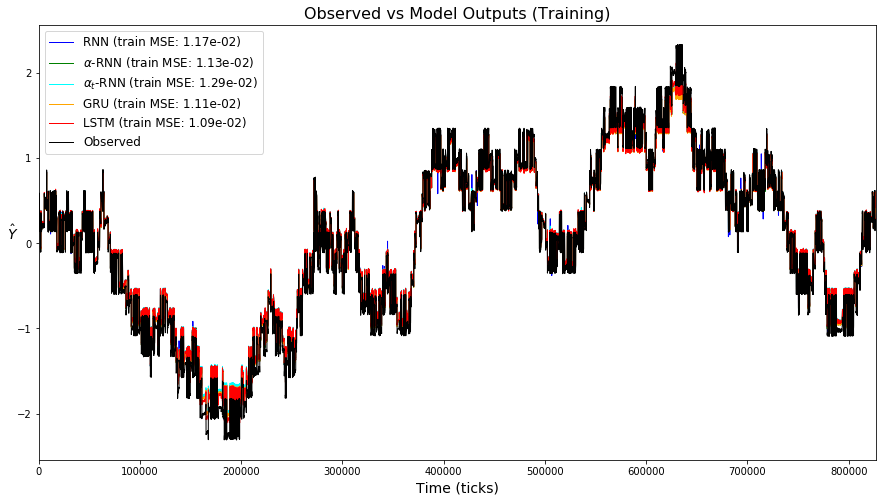

In [28]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//10**4) # set `None` to disable downsampling

fig = plt.figure(figsize=(15,8))
x_vals = np.arange(len(y_train))[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
plt.xlim(x_vals.min(), x_vals.max())
plt.xlabel('Time (ticks)', fontsize=14)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

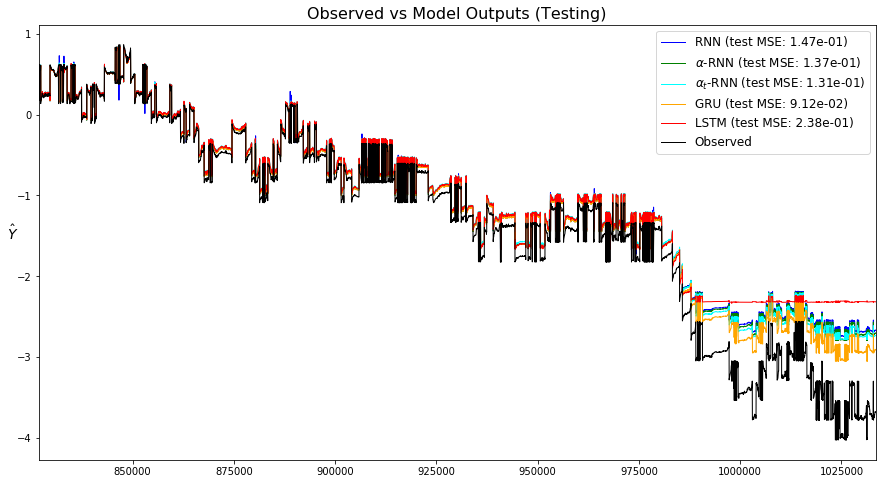

In [29]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_test[l:u])//10**4) # set `None` to disable downsampling

fig = plt.figure(figsize=(15,8))
x_vals = len(y_train) + np.arange(len(y_test))[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
plt.xlim(x_vals.min(), x_vals.max())
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

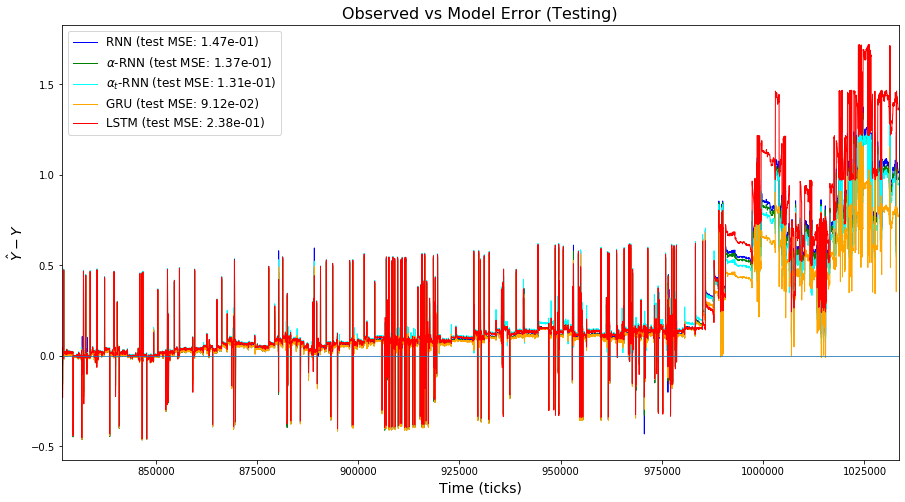

In [30]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_test[l:u])//10**4) # set `None` to disable downsampling

fig = plt.figure(figsize=(15,8))
x_vals = len(y_train) + np.arange(len(y_test))[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.axhline(0, linewidth=0.8)
plt.xlim(x_vals.min(), x_vals.max())
plt.xlabel('Time (ticks)', fontsize=14)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

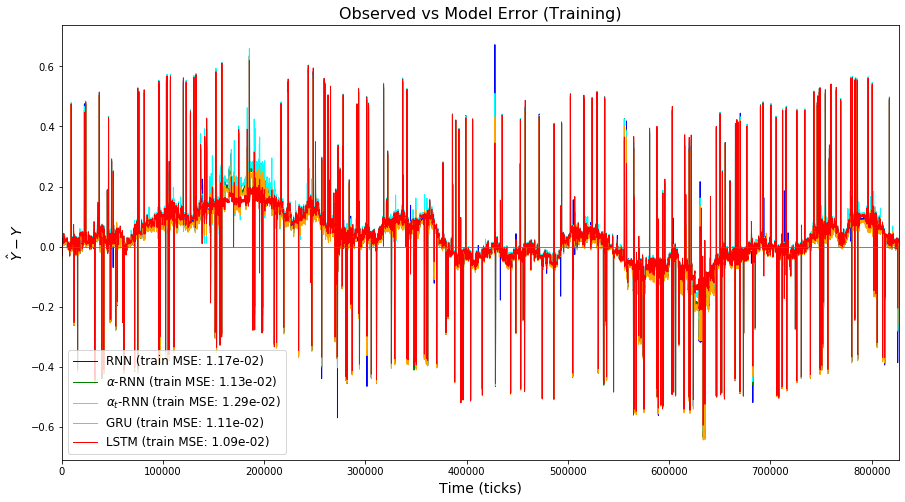

In [31]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//10**4) # set `None` to disable downsampling

fig = plt.figure(figsize=(15,8))
x_vals = np.arange(len(y_train))[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.axhline(0, linewidth=0.8)
plt.xlim(x_vals.min(), x_vals.max())
plt.xlabel('Time (ticks)', fontsize=14)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);

### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$  
as a test statistic for the null hypothesis $H_0:\tau_1=\dots=\tau_m=0$ against the alternative hypothesis $H_a:\tau_i\neq 0$ for some $i\in\{1,\dots,m\}$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$
This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [32]:
# number of samples to use for computing test statistic
n = 100000

In [33]:
params.keys()

dict_keys(['rnn', 'alpharnn', 'alphatrnn', 'gru', 'lstm'])

In [35]:
key = 'alpharnn'
predicted = params[key]['pred_test']
residual = df_test[-n:] - predicted[-n:]

In [36]:
lb, p = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

The Box-Ljung test statistics are

In [37]:
lb

array([  99313.55883373,  197866.9592058 ,  295638.67404428,
        392674.03256396,  488999.41277665,  584631.01518258,
        679582.49035463,  773845.09585051,  867415.5129382 ,
        960306.05492331, 1052903.28079435, 1145408.7195795 ,
       1237881.04961407, 1330321.95966486, 1422714.40017565,
       1515056.57472546, 1607341.96927278, 1699565.21418598,
       1791730.42475522, 1883832.48686961])

The p-values are

In [38]:
p

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])